In [22]:
import numpy as np
from tensorflow import set_random_seed
from numpy.random import seed
import pandas as pd
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import datetime
import matplotlib.pyplot as plt

In [23]:
#dataset_empty = 0
set_random_seed(1)
seed(1)

In [24]:
#Convert the train data into time series
def time_series_data(data, window, lag):
    dropnan = True
    cols, names = list(), list()

    for i in range(window, 0, -1):
        #past time series data (t-)
        cols.append(data.shift(i))
        names = names + [('%s(t-%d)' % (col, i)) for col in data.columns]
    
    #current time series data (t = 0)
    cols.append(data)
    names = names + [('%s(t)' % (col)) for col in data.columns]
    
    #future data (t + lag)
    cols.append(data.shift(-lag))
    names = names + [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    #all data
    all_data = pd.concat(cols, axis=1)
    all_data.columns = names
    
    #drops rows with NaN
    if dropnan:
        all_data.dropna(inplace=True)
    return all_data

In [25]:
dataset = pd.read_csv('sales data-set.csv', usecols = ['Store', 'Item', 'Date', 'Weekly_Sales'])
train = dataset[['Store', 'Item', 'Date', 'Weekly_Sales']]
train = train.loc[(train['Store'] == 1) & (train['Item'] == 1)]
#train = train[(train['Date'] >= '2012-01-01')]
#train = train.loc[train['Store'] == 3]

print(train.head())

       Store  Item        Date  Weekly_Sales
0          1     1  2010-02-07      24924.50
2955       1     1  2010-02-14      46039.49
5911       1     1  2010-02-21      41595.55
8888       1     1  2010-02-28      19403.54
11839      1     1  2010-03-07      21827.90


In [26]:
#Re-arranges the train dataset to apply shift methods
train_r = train.sort_values('Date').groupby(['Item', 'Store', 'Date'], as_index=False)
train_r = train_r.agg({'Weekly_Sales':['mean']})
train_r.columns = ['Item', 'Store', 'Date', 'Weekly_Sales']
#cols_to_drop = ['Date']
#train_r.drop(cols_to_drop, axis=1, inplace=True)
train_r.head()

,Item,Store,Date,Weekly_Sales
0,1,1,2010-02-07,24924.50
1,1,1,2010-02-14,46039.49
2,1,1,2010-02-21,41595.55
3,1,1,2010-02-28,19403.54
4,1,1,2010-03-07,21827.90


In [27]:
#weekly sales in 10 thousand dollars
train_r['Weekly_Sales'] = train_r['Weekly_Sales'] / 10000
train_r.head()

,Item,Store,Date,Weekly_Sales
0,1,1,2010-02-07,2.492450
1,1,1,2010-02-14,4.603949
2,1,1,2010-02-21,4.159555
3,1,1,2010-02-28,1.940354
4,1,1,2010-03-07,2.182790


In [28]:
#the model will use last 117 weekly sales data and 
#current timestep (7 days) to forecast next weekly sales data 12 weeks ahead

window = 117
lag = 12

series_data = time_series_data(train_r, window, lag)
series_data.head()

,Item(t-117),Store(t-117),Date(t-117),Weekly_Sales(t-117),Item(t-116),Store(t-116),Date(t-116),Weekly_Sales(t-116),Item(t-115),Store(t-115),...,Date(t-1),Weekly_Sales(t-1),Item(t),Store(t),Date(t),Weekly_Sales(t),Item(t+12),Store(t+12),Date(t+12),Weekly_Sales(t+12)
117,1.0,1.0,2010-02-07,2.492450,1.0,1.0,2010-02-14,4.603949,1.0,1.0,...,2012-04-29,1.634760,1,1,2012-05-06,1.714744,1.0,1.0,2012-07-29,1.573118
118,1.0,1.0,2010-02-14,4.603949,1.0,1.0,2010-02-21,4.159555,1.0,1.0,...,2012-05-06,1.714744,1,1,2012-05-13,1.816420,1.0,1.0,2012-08-05,1.662831
119,1.0,1.0,2010-02-21,4.159555,1.0,1.0,2010-02-28,1.940354,1.0,1.0,...,2012-05-13,1.816420,1,1,2012-05-20,1.851779,1.0,1.0,2012-08-12,1.611992
120,1.0,1.0,2010-02-28,1.940354,1.0,1.0,2010-03-07,2.182790,1.0,1.0,...,2012-05-20,1.851779,1,1,2012-05-27,1.696355,1.0,1.0,2012-08-19,1.733070
121,1.0,1.0,2010-03-07,2.182790,1.0,1.0,2010-03-14,2.104339,1.0,1.0,...,2012-05-27,1.696355,1,1,2012-06-03,1.606549,1.0,1.0,2012-08-26,1.628640


In [29]:
future_dates = series_data[['Date(t+%d)' % lag]]
future_dates

,Date(t+12)
117,2012-07-29
118,2012-08-05
119,2012-08-12
120,2012-08-19
121,2012-08-26
122,2012-09-02
123,2012-09-09
124,2012-09-16
125,2012-09-23
126,2012-09-30


In [30]:
#drops last record of (t + lag)
last_record_item = 'Item(t-%d)' % window
last_record_store = 'Store(t-%d)' % window
series_data = series_data[(series_data['Item(t)'] == series_data[last_record_item])]
series_data = series_data[(series_data['Store(t)'] == series_data[last_record_store])]

#drops Item and Store columns
cols_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Item', 'Store', 'Date']]
for i in range(window, 0, -1):
    cols_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Item', 'Store', 'Date']]

series_data.drop(cols_to_drop, axis=1, inplace=True)
series_data.drop(['Item(t)', 'Store(t)', 'Date(t)'], axis=1, inplace=True)

lbls_col = 'Weekly_Sales(t+%d)' % lag
lbls = series_data[lbls_col]
series_data = series_data.drop(lbls_col, axis=1)

series_data.head()

,Weekly_Sales(t-117),Weekly_Sales(t-116),Weekly_Sales(t-115),Weekly_Sales(t-114),Weekly_Sales(t-113),Weekly_Sales(t-112),Weekly_Sales(t-111),Weekly_Sales(t-110),Weekly_Sales(t-109),Weekly_Sales(t-108),...,Weekly_Sales(t-9),Weekly_Sales(t-8),Weekly_Sales(t-7),Weekly_Sales(t-6),Weekly_Sales(t-5),Weekly_Sales(t-4),Weekly_Sales(t-3),Weekly_Sales(t-2),Weekly_Sales(t-1),Weekly_Sales(t)
117,2.492450,4.603949,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,...,2.011303,2.114007,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744
118,4.603949,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,...,2.114007,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420
119,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,...,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779
120,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,...,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355
121,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,1.741394,...,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355,1.606549


In [31]:
#train and test split

X_train, X_test, Y_train, Y_test = train_test_split(series_data, lbls.values, test_size=0.9, random_state=0, shuffle=False)
X_test = series_data
#print('Train dataset:', X_train.shape)
print('Test dataset:', X_test.shape)
X_test

Test dataset: (14, 118)


,Weekly_Sales(t-117),Weekly_Sales(t-116),Weekly_Sales(t-115),Weekly_Sales(t-114),Weekly_Sales(t-113),Weekly_Sales(t-112),Weekly_Sales(t-111),Weekly_Sales(t-110),Weekly_Sales(t-109),Weekly_Sales(t-108),...,Weekly_Sales(t-9),Weekly_Sales(t-8),Weekly_Sales(t-7),Weekly_Sales(t-6),Weekly_Sales(t-5),Weekly_Sales(t-4),Weekly_Sales(t-3),Weekly_Sales(t-2),Weekly_Sales(t-1),Weekly_Sales(t)
117,2.492450,4.603949,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,...,2.011303,2.114007,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744
118,4.603949,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,...,2.114007,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420
119,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,...,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779
120,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,...,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355
121,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,1.741394,...,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355,1.606549
122,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,1.741394,1.892674,...,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355,1.606549,1.766600
123,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,1.741394,1.892674,1.477304,...,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355,1.606549,1.766600,1.755882
124,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,1.741394,1.892674,1.477304,1.558043,...,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355,1.606549,1.766600,1.755882,1.663341
125,5.725843,4.296091,1.759696,1.614535,1.655511,1.741394,1.892674,1.477304,1.558043,1.755809,...,1.634760,1.714744,1.816420,1.851779,1.696355,1.606549,1.766600,1.755882,1.663341,1.572282
126,4.296091,1.759696,1.614535,1.655511,1.741394,1.892674,1.477304,1.558043,1.755809,1.663762,...,1.714744,1.816420,1.851779,1.696355,1.606549,1.766600,1.755882,1.663341,1.572282,1.782337


In [32]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
#print('Train dataset:', X_train_series.shape)
print('Test dataset:', X_test_series.shape)

Test dataset: (14, 118, 1)


In [33]:
#CNN-LSTM
subsequences = 2
time_steps = X_test_series.shape[1] // subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, time_steps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, time_steps, 1))
#print('Train dataset:', X_train_series_sub.shape)
print('Test dataset:', X_test_series_sub.shape)

Test dataset: (14, 2, 59, 1)


In [34]:
epochs = 2000
batch = 32
learning_rate = 0.00000001
adam = optimizers.Adam(learning_rate)

In [35]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 1, activation = 'relu'), input_shape = (None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(60, activation = 'relu'))
model_cnn_lstm.add(Dropout(0.1))
model_cnn_lstm.add(Dense(30, activation = 'relu'))
model_cnn_lstm.add(Dropout(0.1))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss = 'mse', optimizer = 'adam')
model_cnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, None, 59, 64)      128       
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 29, 64)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 1856)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                460080    
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
__________

In [36]:
#load from saved file
file_name = "cnn_lstm_weights_s1_i1.hdf5"

model_cnn_lstm.load_weights(file_name)
model_cnn_lstm.compile(loss = 'mse', optimizer = 'adam')

#prediction
#cnn_lstm_train_prediction = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_test_prediction = model_cnn_lstm.predict(X_test_series_sub)

test_p = []
for i in range(0, cnn_lstm_test_prediction.shape[0]):
    test_p.append(cnn_lstm_test_prediction[i][0])

test_p

[1.5581621,
 1.5834031,
 1.5680783,
 1.6547753,
 1.6032249,
 1.6465869,
 1.839685,
 1.9275924,
 1.8834236,
 1.8141878,
 2.0686913,
 2.1672068,
 2.35099,
 2.6988297]

In [37]:
predictions = pd.DataFrame({'Date' : list(future_dates['Date(t+12)']),
                            'Weekly_Sales' : test_p})
predictions

,Date,Weekly_Sales
0,2012-07-29,1.558162
1,2012-08-05,1.583403
2,2012-08-12,1.568078
3,2012-08-19,1.654775
4,2012-08-26,1.603225
5,2012-09-02,1.646587
6,2012-09-09,1.839685
7,2012-09-16,1.927592
8,2012-09-23,1.883424
9,2012-09-30,1.814188


In [38]:
train_p = train_r
actual_data = train_p.tail(117 + 12)
train_p.drop(['Item', 'Store'], axis=1, inplace=True)
actual_data.drop(['Item', 'Store'], axis=1, inplace=True)
window = 117
lag = 12

for k in range(0, 12):
    X_test_predict = train_p.tail(117 + 12)    
    max_date = X_test_predict['Date'].max()
    next_date = datetime.datetime.strptime(max_date, '%Y-%m-%d').date() + timedelta(days=7)
    df = pd.DataFrame({'Date' : next_date.strftime("%Y-%m-%d"), 
                       'Weekly_Sales' : [0]})
    X_test_predict = X_test_predict.append(df)
    train_p = train_p.append(df)
    predictions = predictions.append(df)
    actual_data = actual_data.append(df)
    
    X_test_predict = X_test_predict.reset_index(drop = True)
    train_p = train_p.reset_index(drop = True)
    predictions = predictions.reset_index(drop = True)
    actual_data = actual_data.reset_index(drop = True)
        
    series_data_p = time_series_data(X_test_predict, window, lag)

    cols_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Date']]
    for i in range(window, 0, -1):
        cols_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Date']]

    series_data_p.drop(cols_to_drop, axis=1, inplace=True)
    series_data_p.drop(['Date(t)'], axis=1, inplace=True)

    lbls_col = 'Weekly_Sales(t+%d)' % lag
    lbls = series_data_p[lbls_col]
    series_data_p = series_data_p.drop(lbls_col, axis=1)

    X_test_series_p = series_data_p.values.reshape((series_data_p.shape[0], X_test.shape[1], 1))

    subsequences = 2
    time_steps_p = X_test_series_p.shape[1] // subsequences
    X_test_series_sub_p = X_test_series_p.reshape((X_test_series_p.shape[0], subsequences, time_steps_p, 1))   
    
    cnn_lstm_test_prediction = model_cnn_lstm.predict(X_test_series_sub_p)
    
    train_p.loc[(train_p['Date'] == next_date.strftime("%Y-%m-%d"))  & (train_p['Weekly_Sales'] == 0), ['Weekly_Sales']] = cnn_lstm_test_prediction[0][0]
    predictions.loc[(predictions['Date'] == next_date.strftime("%Y-%m-%d")) & (predictions['Weekly_Sales'] == 0), ['Weekly_Sales']] = cnn_lstm_test_prediction[0][0]
    
predictions

,Date,Weekly_Sales
0,2012-07-29,1.558162
1,2012-08-05,1.583403
2,2012-08-12,1.568078
3,2012-08-19,1.654775
4,2012-08-26,1.603225
5,2012-09-02,1.646587
6,2012-09-09,1.839685
7,2012-09-16,1.927592
8,2012-09-23,1.883424
9,2012-09-30,1.814188


In [39]:
graph_data = actual_data.merge(predictions, left_on = ['Date'], 
                              right_on = ['Date'], how = 'outer')
graph_data = graph_data.loc[graph_data['Date'] >= '2012-07-29']
graph_data.loc[graph_data['Weekly_Sales_x'] == 0, ['Weekly_Sales_x']] = np.nan #Weekly_Sales_x is actual data and Weekly_Sales_y is the predicted data
graph_data

,Date,Weekly_Sales_x,Weekly_Sales_y
115,2012-07-29,1.573118,1.558162
116,2012-08-05,1.662831,1.583403
117,2012-08-12,1.611992,1.568078
118,2012-08-19,1.733070,1.654775
119,2012-08-26,1.628640,1.603225
120,2012-09-02,1.668024,1.646587
121,2012-09-09,1.832237,1.839685
122,2012-09-16,1.961622,1.927592
123,2012-09-23,1.925150,1.883424
124,2012-09-30,1.894781,1.814188


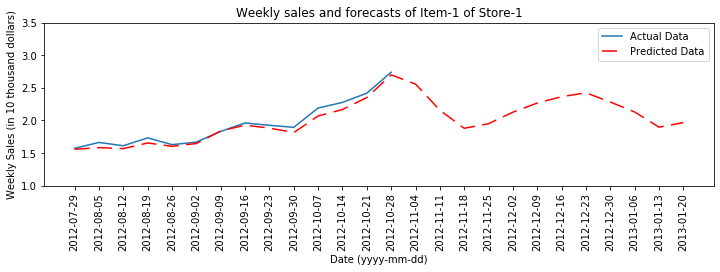

<Figure size 432x288 with 0 Axes>

In [41]:
plt.subplots(figsize=(12, 3))
plt.plot(graph_data.Date, graph_data.Weekly_Sales_x)
plt.plot(graph_data.Date, graph_data.Weekly_Sales_y, dashes=[10, 5, 10, 5], color='red')
plt.legend(['Actual Data', 'Predicted Data'], loc='upper right')
plt.yticks(np.arange(1, 4, 0.5))
plt.xticks(graph_data.Date, rotation=90)
plt.title('Weekly sales and forecasts of Item-1 of Store-1')
plt.xlabel('Date (yyyy-mm-dd)')
plt.ylabel('Weekly Sales (in 10 thousand dollars)')

plt.show()
plt.savefig('images\Weekly sales and forecasts of Item-1 of Store-1.png', bbox_inches='tight')